In [53]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from reddit_dataset import PoliticalStancesDataset

In [54]:
train_data = PoliticalStancesDataset("./dataset_finalized.csv", train=True)
test_data = PoliticalStancesDataset("./dataset_finalized.csv", train=False)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else  "cpu")
#device = torch.device("cpu")

In [56]:
class RNN(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_rnnlayers, num_outputs,dropout):
        super(RNN, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_rnnlayers = num_rnnlayers
        self.num_outputs = num_outputs
        self.sigmoid = nn.Sigmoid()
        self.rnn = nn.LSTM(
            input_size=self.num_inputs,
            hidden_size=self.num_hidden,
            num_layers=self.num_rnnlayers,
            batch_first=True,
            dropout = dropout
            )
        self.fc = nn.Linear(self.num_hidden, self.num_outputs)
    def forward(self,X): 
        h0 = torch.zeros(self.num_rnnlayers, X.size(0),
                         self.num_hidden,device = device)
        c0 = torch.zeros(self.num_rnnlayers, X.size(0),
                         self.num_hidden,device = device)
        out, _ = self.rnn(X, (h0, c0))
        out, _ = torch.max(out, 1)
        out = self.fc(out)

        return out

In [57]:
model = RNN(num_inputs=25, num_hidden=80, num_rnnlayers=4, num_outputs=1, dropout = 0.4)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)

In [58]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}')
  
  return train_losses, test_losses

In [59]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=70) #change this back to resenable amount later

Epoch 1/70, Train Loss: 0.6930,       Test Loss: 0.6926
Epoch 2/70, Train Loss: 0.6804,       Test Loss: 0.6737
Epoch 3/70, Train Loss: 0.6716,       Test Loss: 0.6739
Epoch 4/70, Train Loss: 0.6677,       Test Loss: 0.6676
Epoch 5/70, Train Loss: 0.6659,       Test Loss: 0.6664
Epoch 6/70, Train Loss: 0.6639,       Test Loss: 0.6628
Epoch 7/70, Train Loss: 0.6622,       Test Loss: 0.6681
Epoch 8/70, Train Loss: 0.6616,       Test Loss: 0.6614
Epoch 9/70, Train Loss: 0.6601,       Test Loss: 0.6591
Epoch 10/70, Train Loss: 0.6587,       Test Loss: 0.6591
Epoch 11/70, Train Loss: 0.6569,       Test Loss: 0.6572
Epoch 12/70, Train Loss: 0.6560,       Test Loss: 0.6620
Epoch 13/70, Train Loss: 0.6546,       Test Loss: 0.6552
Epoch 14/70, Train Loss: 0.6529,       Test Loss: 0.6529
Epoch 15/70, Train Loss: 0.6527,       Test Loss: 0.6524
Epoch 16/70, Train Loss: 0.6510,       Test Loss: 0.6507
Epoch 17/70, Train Loss: 0.6497,       Test Loss: 0.6502
Epoch 18/70, Train Loss: 0.6482,       T

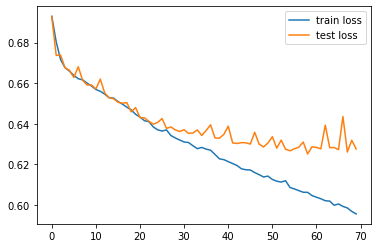

In [60]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [61]:
torch.save(model, "saved_model.pt")

In [62]:
model = torch.load("saved_model.pt")

In [63]:
model.eval()
n_correct = 0.
n_total = 0.
predict_list = np.array([0]) #lazy programming will change later
target_list = np.array([0])
accuracy = []
for index , (inputs , targets) in enumerate(test_loader):
    inputs, targets = inputs.to(device) , targets.to(device)
    outputs = model.forward(inputs)
    predictions = (outputs > 0)

    predict_list = np.vstack((predict_list,predictions.cpu().numpy()))
    target_list = np.vstack((target_list,targets.cpu().numpy()))
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.6465


In [64]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  

Confusion matrix, without normalization
[[2067 1472]
 [1014 2479]]


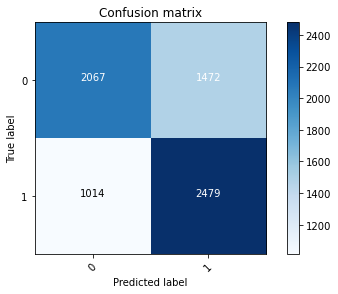

In [65]:
target_list
cm = confusion_matrix(target_list, 1*predict_list)
cm[0][0] = cm[0][0] -1
plot_confusion_matrix(cm, [0,1])